In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import gensim.downloader as api
from PIL import Image
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input, Embedding,TextVectorization)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from tensorboard.plugins import projector

# Data Preparation

## Downloading

In [2]:
BATCH_SIZE=64

In [3]:
train_ds,val_ds,test_ds=tfds.load('imdb_reviews', split=['train', 'test[:50%]', 'test[50%:]'],as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteUABJN0/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteUABJN0/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteUABJN0/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [4]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

## Cleaning

In [5]:
def standardization(input_data):
    '''
    Input: raw reviews
    output: standardized reviews
    '''
    lowercase=tf.strings.lower(input_data)
    no_tag=tf.strings.regex_replace(lowercase,"<[^>]+>","")
    output=tf.strings.regex_replace(no_tag,"[%s]"%re.escape(string.punctuation),"")

    return output

In [6]:
standardization(tf.constant("<u>In the movie?, </u>man called Tévèz, went to a friend’s pl**ce and they had a tensed discussion. I don’t love this movie! would you?<br> <br /><br />T"))

<tf.Tensor: shape=(), dtype=string, numpy=b'in the movie man called t\xc3\xa9v\xc3\xa8z went to a friend\xe2\x80\x99s plce and they had a tensed discussion i don\xe2\x80\x99t love this movie would you t'>

In [7]:
VOCAB_SIZE=10000
SEQUENCE_LENGTH=250
EMBEDDING_DIM=300

In [8]:
vectorize_layer=TextVectorization(
    standardize=standardization,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH
)

In [9]:
training_data=train_ds.map(lambda x,y:x)# input x and y and outputx
vectorize_layer.adapt(training_data)# adapt the vectorize_layer to the training data

In [10]:
len(vectorize_layer.get_vocabulary())

10000

In [11]:
for review,label in train_ds.take(2):
  print(review)
  print(label)

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on t

In [12]:
def vectorizer(review,label):
    return vectorize_layer(review),label

In [13]:
train_dataset=train_ds.map(vectorizer)
val_dataset=val_ds.map(vectorizer)

In [14]:
for review,label in train_ds.take(1):
  print(review)
  print(label)

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


In [15]:
vectorize_layer.get_vocabulary()[411]

'absolutely'

In [16]:
train_dataset=train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset=val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model

## RNN

In [ ]:
inputs=np.random.random([32, 10, 8]).astype(np.float32)
simple_rnn=tf.keras.layers.SimpleRNN(25)
output=simple_rnn(inputs)
print(output.shape)

(32, 25)


In [ ]:
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),
    SimpleRNN(32),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 64)           640000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 643137 (2.45 MB)
Trainable params: 643137 (2.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/sentiment_analysis/rnn.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[model_checkpoint_callback])

Epoch 1/10
391/391 [==============================] - 146s 357ms/step - loss: 0.6951 - accuracy: 0.4992 - val_loss: 0.6932 - val_accuracy: 0.5001


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/10
391/391 [==============================] - 94s 240ms/step - loss: 0.6879 - accuracy: 0.5266 - val_loss: 0.6942 - val_accuracy: 0.4989
Epoch 3/10
391/391 [==============================] - 99s 254ms/step - loss: 0.6715 - accuracy: 0.5792 - val_loss: 0.6976 - val_accuracy: 0.5016
Epoch 4/10
391/391 [==============================] - 100s 255ms/step - loss: 0.6405 - accuracy: 0.6380 - val_loss: 0.7084 - val_accuracy: 0.4974
Epoch 5/10
391/391 [==============================] - 98s 252ms/step - loss: 0.5867 - accuracy: 0.7146 - val_loss: 0.7356 - val_accuracy: 0.4999
Epoch 6/10
391/391 [==============================] - 94s 240ms/step - loss: 0.5196 - accuracy: 0.7815 - val_loss: 0.7557 - val_accuracy: 0.5072
Epoch 7/10
391/391 [==============================] - 93s 239ms/step - loss: 0.4493 - accuracy: 0.8350 - val_loss: 0.7580 - val_accuracy: 0.5170
Epoch 8/10
391/391 [==============================] - 95s 242ms/step - loss: 0.4070 - accuracy: 0.8555 - val_loss: 0.7756 - val_a

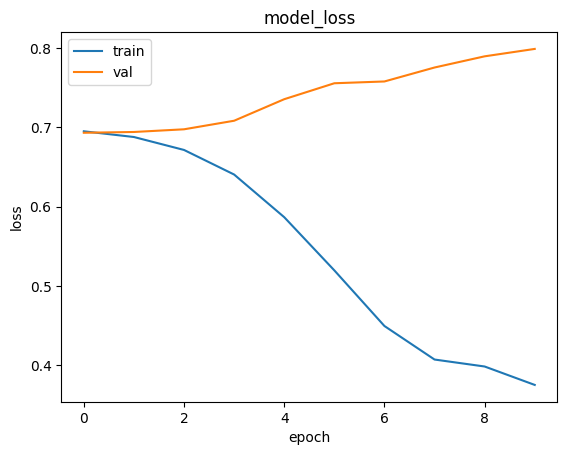

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

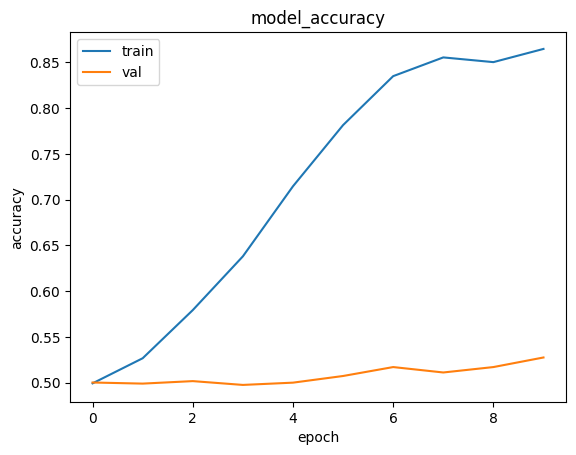

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## LSTM

In [17]:
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    Bidirectional(LSTM(64,return_sequences=True)),
    Bidirectional(LSTM(32)),

    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 64)           640000    
                                                                 
 bidirectional (Bidirection  (None, 250, 128)          66048     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [20]:
checkpoint_filepath = '/content/drive/MyDrive/sentiment_analysis/lstm.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [21]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [22]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[model_checkpoint_callback])

Epoch 1/10
391/391 [==============================] - 76s 168ms/step - loss: 0.6304 - accuracy: 0.6148 - val_loss: 0.4057 - val_accuracy: 0.8242


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


391/391 [==============================] - 19s 50ms/step - loss: 0.3318 - accuracy: 0.8667 - val_loss: 0.3291 - val_accuracy: 0.8643
Epoch 3/10
391/391 [==============================] - 21s 53ms/step - loss: 0.2441 - accuracy: 0.9127 - val_loss: 0.3682 - val_accuracy: 0.8652
Epoch 4/10
391/391 [==============================] - 20s 52ms/step - loss: 0.2008 - accuracy: 0.9318 - val_loss: 0.4482 - val_accuracy: 0.8492
Epoch 5/10
391/391 [==============================] - 19s 48ms/step - loss: 0.1748 - accuracy: 0.9442 - val_loss: 0.4144 - val_accuracy: 0.8530
Epoch 6/10
391/391 [==============================] - 21s 53ms/step - loss: 0.1584 - accuracy: 0.9472 - val_loss: 0.4127 - val_accuracy: 0.8519
Epoch 7/10
391/391 [==============================] - 20s 52ms/step - loss: 0.1301 - accuracy: 0.9590 - val_loss: 0.4763 - val_accuracy: 0.8493
Epoch 8/10
391/391 [==============================] - 19s 48ms/step - loss: 0.1132 - accuracy: 0.9666 - val_loss: 0.5129 - val_accuracy: 0.8460
Epo

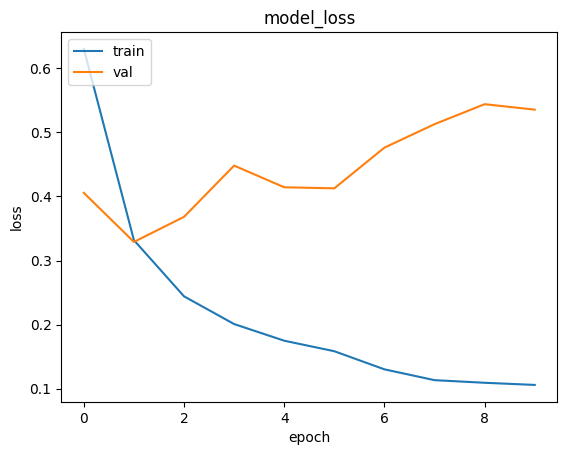

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

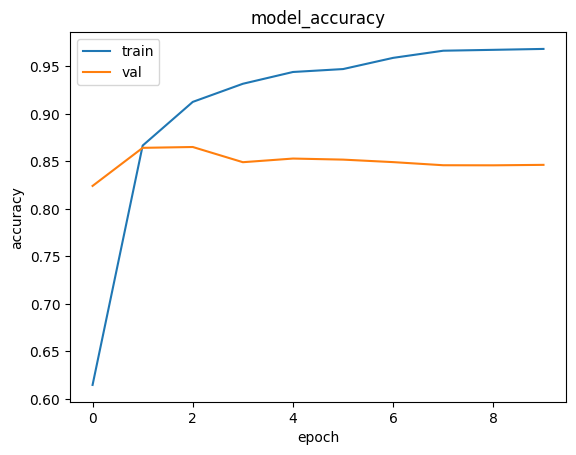

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(test_dataset)

196/196 [==============================] - 4s 22ms/step - loss: 0.5310 - accuracy: 0.8474


[0.531029462814331, 0.8473600149154663]

## GRU

In [26]:
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    Bidirectional(GRU(64,return_sequences=True)),
    Bidirectional(GRU(32)),

    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 64)           640000    
                                                                 
 bidirectional_2 (Bidirecti  (None, 250, 128)          49920     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                31104     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [27]:
checkpoint_filepath = '/content/drive/MyDrive/sentiment_analysis/gru.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [28]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [29]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[])

Epoch 1/10
391/391 [==============================] - 53s 114ms/step - loss: 0.6874 - accuracy: 0.5526 - val_loss: 0.6546 - val_accuracy: 0.6223
Epoch 2/10
391/391 [==============================] - 19s 48ms/step - loss: 0.4141 - accuracy: 0.8187 - val_loss: 0.3367 - val_accuracy: 0.8552
Epoch 3/10
391/391 [==============================] - 32s 81ms/step - loss: 0.2654 - accuracy: 0.8993 - val_loss: 0.3361 - val_accuracy: 0.8638
Epoch 4/10
391/391 [==============================] - 19s 48ms/step - loss: 0.2161 - accuracy: 0.9241 - val_loss: 0.3577 - val_accuracy: 0.8612
Epoch 5/10
391/391 [==============================] - 20s 50ms/step - loss: 0.1950 - accuracy: 0.9330 - val_loss: 0.4283 - val_accuracy: 0.8498
Epoch 6/10
391/391 [==============================] - 20s 50ms/step - loss: 0.1754 - accuracy: 0.9395 - val_loss: 0.4091 - val_accuracy: 0.8543
Epoch 7/10
391/391 [==============================] - 19s 48ms/step - loss: 0.1528 - accuracy: 0.9488 - val_loss: 0.4329 - val_accuracy

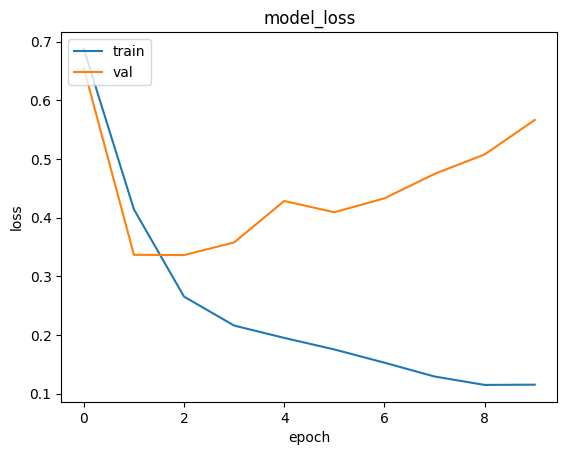

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

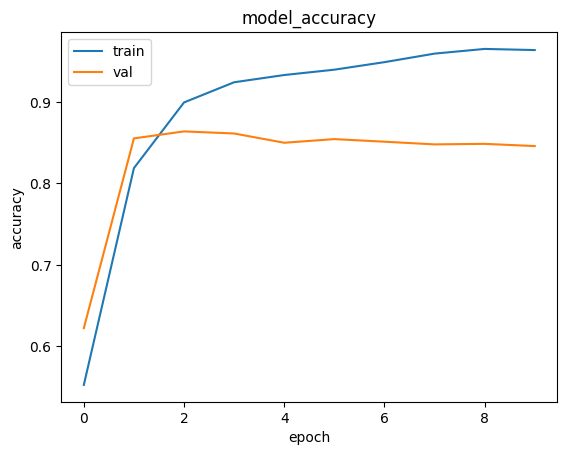

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [32]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(test_dataset)

196/196 [==============================] - 5s 24ms/step - loss: 0.5577 - accuracy: 0.8474


[0.557661235332489, 0.8474400043487549]

## 1D Conv

In [33]:
EMBEDDING_DIM=300
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    Conv1D(32, 3, activation='relu',),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 250, 300)          3000000   
                                                                 
 conv1d (Conv1D)             (None, 248, 32)           28832     
                                                                 
 flatten (Flatten)           (None, 7936)              0         
                                                                 
 dense_4 (Dense)             (None, 32)                253984    
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3282849 (12.52 MB)
Trainable params: 328

In [34]:
checkpoint_filepath = '/content/drive/MyDrive/sentiment_analysis/conv_1d.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [35]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [36]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[model_checkpoint_callback])

Epoch 1/10
391/391 [==============================] - 51s 124ms/step - loss: 0.6906 - accuracy: 0.5245 - val_loss: 0.6803 - val_accuracy: 0.5675
Epoch 2/10
391/391 [==============================] - 12s 32ms/step - loss: 0.4872 - accuracy: 0.7755 - val_loss: 0.3412 - val_accuracy: 0.8566
Epoch 3/10
391/391 [==============================] - 9s 24ms/step - loss: 0.2786 - accuracy: 0.8912 - val_loss: 0.3087 - val_accuracy: 0.8698
Epoch 4/10
391/391 [==============================] - 9s 23ms/step - loss: 0.2130 - accuracy: 0.9224 - val_loss: 0.3187 - val_accuracy: 0.8674
Epoch 5/10
391/391 [==============================] - 9s 23ms/step - loss: 0.1714 - accuracy: 0.9418 - val_loss: 0.3413 - val_accuracy: 0.8628
Epoch 6/10
391/391 [==============================] - 9s 24ms/step - loss: 0.1384 - accuracy: 0.9561 - val_loss: 0.3767 - val_accuracy: 0.8581
Epoch 7/10
391/391 [==============================] - 9s 24ms/step - loss: 0.1137 - accuracy: 0.9666 - val_loss: 0.4072 - val_accuracy: 0.8

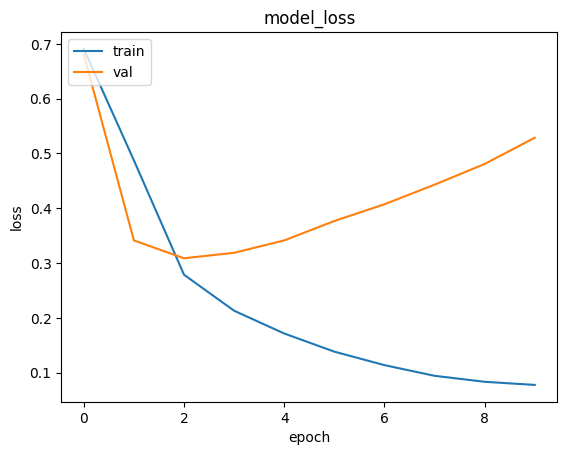

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

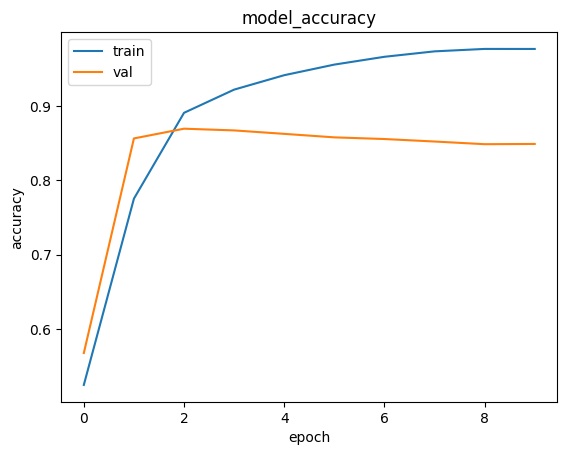

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [39]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(test_dataset)

196/196 [==============================] - 3s 15ms/step - loss: 0.5202 - accuracy: 0.8451


[0.5202436447143555, 0.8451200127601624]

## W2Vec

In [ ]:
word2vec=api.load('word2vec-google-news-300')

In [ ]:
word2vec.vectors.shape

In [ ]:
#print(word2vec.vocab)
len(word2vec['The'])

In [ ]:
word2vec.most_similar('Man')

In [ ]:
def first_caps(word):
  return word[0].upper()+word[1:]

In [ ]:
vectorize_layer.get_vocabulary()[2]

In [ ]:
first_caps(vectorize_layer.get_vocabulary()[2])

In [ ]:
pretrained_embeddings=[]

In [ ]:
len(vectorize_layer.get_vocabulary())

In [ ]:
for i in range(len(vectorize_layer.get_vocabulary())):
  try:
    pretrained_embeddings.append(word2vec[vectorize_layer.get_vocabulary()[i]])
  except:
    print(vectorize_layer.get_vocabulary()[i])
    try:
      pretrained_embeddings.append(word2vec[first_caps(vectorize_layer.get_vocabulary()[i])])
      print('toupper')
    except:
      print('nosolution')
      pretrained_embeddings.append(random.normal(loc=0, scale=1, size=(EMBEDDING_DIM)))#reloaded_word_vectors[vectorize_layer.get_vocabulary()[i]])
  if i%1000==0:
    print('iis====================================',i)

In [ ]:
#np.save('/content/drive/MyDrive/nlp/sentiment_analysis/pretrained_embeddings',pretrained_embeddings_array)

In [ ]:
pretrained_embeddings_array=np.load('/content/drive/MyDrive/nlp/sentiment_analysis/pretrained_embeddings.npy')

In [ ]:
pretrained_embeddings_array.shape

In [ ]:
EMBEDDING_DIM=300
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(
        VOCAB_SIZE,
        EMBEDDING_DIM,
        embeddings_initializer=tf.keras.initializers.Constant(pretrained_embeddings_array),
        trainable=True,
    ),

    Conv1D(32, 3, activation='relu',),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/sentiment_analysis/conv_1d_word2vec.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[model_checkpoint_callback])

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(test_dataset)

# Testing

In [ ]:
# test_pos="this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes! "
# test_neg="very good start, but movie started becoming boring at some point and unfortunately i didn't feel like this was properly produced as there was too much background noise, and the actors didn't look motivated at all "

In [ ]:
test_data=tf.data.Dataset.from_tensor_slices([["this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes! "],
                                              ["very good start, but movie started becoming interesting at some point and fortunately at some point it started becoming much more fun, though there was too much background noise, so in all i liked this movie "],])

In [ ]:
def vectorizer_test(review):
    return vectorize_layer(review)
test_dataset=test_data.map(vectorizer_test)

In [ ]:
model.predict(test_dataset)

# Inference Ready Model

In [ ]:
inputs = Input(shape=(1,), dtype="string")
vectorized_inputs=vectorize_layer(inputs)
outputs = model(vectorized_inputs)
inference_ready_model = tf.keras.Model(inputs, outputs)
inference_ready_model.summary()

In [ ]:
inference_ready_model.predict(["this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes! ",
                               "very good start, but movie started becoming interesting at some point and fortunately at some point it started becoming much more fun, though there was too much background noise, so in all i liked this movie "])

# Visualizing

In [ ]:
EMBEDDING_DIM=300
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    Conv1D(32, 3, activation='relu',),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
log_dir='logs/imdb/fit/'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'/'

In [ ]:
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir,histogram_freq=1)

In [ ]:
history=model.fit(
    train_dataset.take(34),
    validation_data=val_dataset,
    epochs=1,
    callbacks=[tensorboard_callback])

In [ ]:
with open(os.path.join(log_dir,'metadata.tsv'),"w",encoding="utf-8") as f:
  for i in range(VOCAB_SIZE):
    f.write("{} {}\n".format(i,vectorize_layer.get_vocabulary()[i]))

In [ ]:
embedding_weights=tf.Variable(model.layers[0].get_weights()[0])
print(embedding_weights.shape)

In [ ]:
checkpoint=tf.train.Checkpoint(embedding=embedding_weights)
checkpoint.save(os.path.join(log_dir,"embedding.ckpt"))

config=projector.ProjectorConfig()
embedding=config.embeddings.add()

In [ ]:
embedding.metadata_path='metadata.tsv'
projector.visualize_embeddings(log_dir,config)

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs/imdb/fit/